In [7]:
import pandas as pd

# Load the dataset
df = pd.read_csv("../gait_synth_data.csv")

# Preview the data
df.head()


,participant_id,time,group,walking_speed,sEMG_TA,sEMG_GM,sEMG_VL,sEMG_BF,sEMG_RF,ground_reaction_force
0,0,0.00000,SCI,0.528316,-0.041479,0.083712,0.303155,-0.174263,-0.157551,-78.376470
1,0,0.02004,SCI,0.527787,0.413135,-0.125808,-0.544058,0.174631,-0.092982,42.272260
2,0,0.04008,SCI,0.527259,0.532607,-0.008731,0.217542,1.048596,0.678922,126.164443
3,0,0.06012,SCI,0.526731,0.515984,-0.125115,-0.027868,-0.066913,0.276394,194.500590
4,0,0.08016,SCI,0.526202,0.930584,-0.104086,0.657419,0.805603,0.384965,260.854260


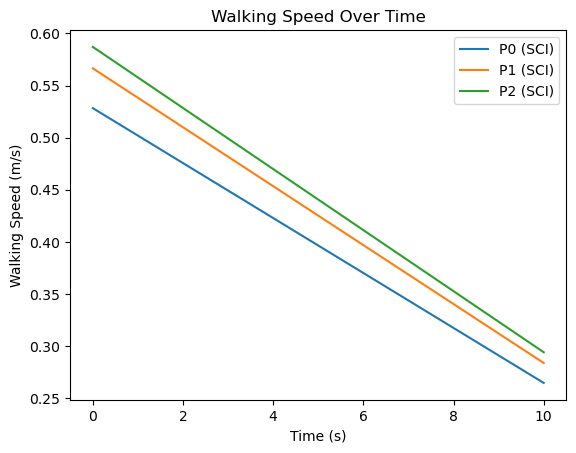

In [8]:
# Participant group counts
df['group'].value_counts()

# Plot walking speed over time for a few participants
import matplotlib.pyplot as plt

for pid in df['participant_id'].unique()[:3]:  # First 3 participants
    subset = df[df['participant_id'] == pid]
    plt.plot(subset['time'], subset['walking_speed'], label=f'P{pid} ({subset["group"].iloc[0]})')

plt.xlabel("Time (s)")
plt.ylabel("Walking Speed (m/s)")
plt.legend()
plt.title("Walking Speed Over Time")
plt.show()


In [9]:
from sklearn.decomposition import NMF

# Select one participant's sEMG data
emg_features = [col for col in df.columns if col.startswith("sEMG")]
participant_emg = df[df['participant_id'] == 0][emg_features].abs()  # NMF requires non-negative values

model = NMF(n_components=2, init='random', random_state=42)
W = model.fit_transform(participant_emg)
H = model.components_

print("Synergy Matrix W shape:", W.shape)
print("Activation Pattern H shape:", H.shape)


Synergy Matrix W shape: (500, 2)
Activation Pattern H shape: (2, 5)


c:\Users\Natha\miniconda3\envs\emg_env\Lib\site-packages\sklearn\decomposition\_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


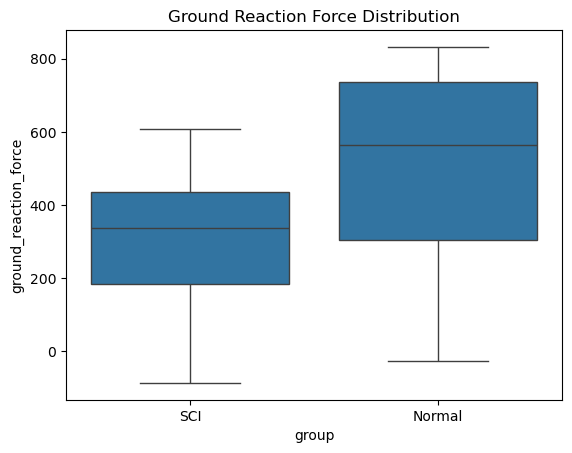

In [10]:
# Compare GRF for SCI vs Normal
import seaborn as sns

sns.boxplot(data=df, x='group', y='ground_reaction_force')
plt.title("Ground Reaction Force Distribution")
plt.show()


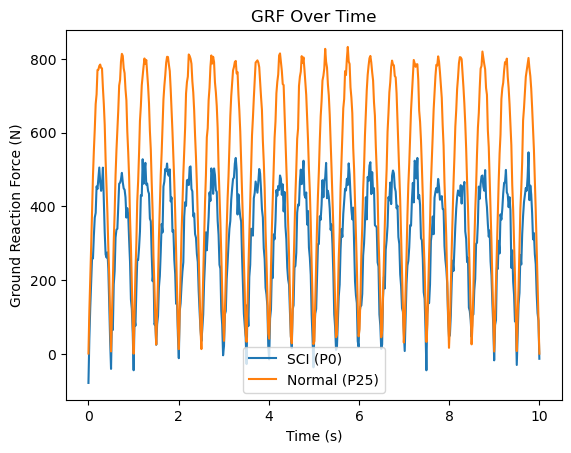

In [11]:
import matplotlib.pyplot as plt

# Pick one SCI and one Normal participant
sci_pid = df[df["group"] == "SCI"]["participant_id"].unique()[0]
normal_pid = df[df["group"] == "Normal"]["participant_id"].unique()[0]

# Filter their data
df_sci = df[df["participant_id"] == sci_pid]
df_normal = df[df["participant_id"] == normal_pid]

# Plot
plt.plot(df_sci["time"], df_sci["ground_reaction_force"], label=f"SCI (P{int(sci_pid)})")
plt.plot(df_normal["time"], df_normal["ground_reaction_force"], label=f"Normal (P{int(normal_pid)})")
plt.xlabel("Time (s)")
plt.ylabel("Ground Reaction Force (N)")
plt.title("GRF Over Time")
plt.legend()
plt.show()


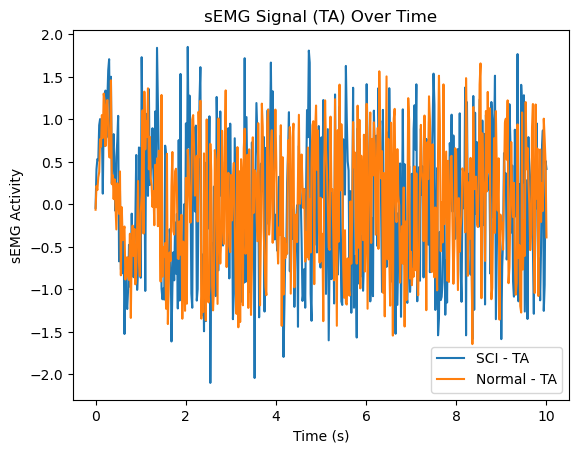

In [12]:
muscle = "TA"  # Try others too: "GM", "VL", "BF", "RF"

plt.plot(df_sci["time"], df_sci[f"sEMG_{muscle}"], label=f"SCI - {muscle}")
plt.plot(df_normal["time"], df_normal[f"sEMG_{muscle}"], label=f"Normal - {muscle}")
plt.title(f"sEMG Signal ({muscle}) Over Time")
plt.xlabel("Time (s)")
plt.ylabel("sEMG Activity")
plt.legend()
plt.show()


In [13]:
# Choose a participant
participant_id = 0
df_p = df[df["participant_id"] == participant_id]

# Get sEMG features
emg_cols = [col for col in df.columns if col.startswith("sEMG_")]
X_emg = df_p[emg_cols].abs().values  # NMF requires non-negative input


In [14]:
# Set number of synergies (you can experiment with 2–5)
n_synergies = 2

model = NMF(n_components=n_synergies, init="random", random_state=42, max_iter=1000)
W = model.fit_transform(X_emg)  # Temporal coefficients
H = model.components_           # Muscle synergy weights


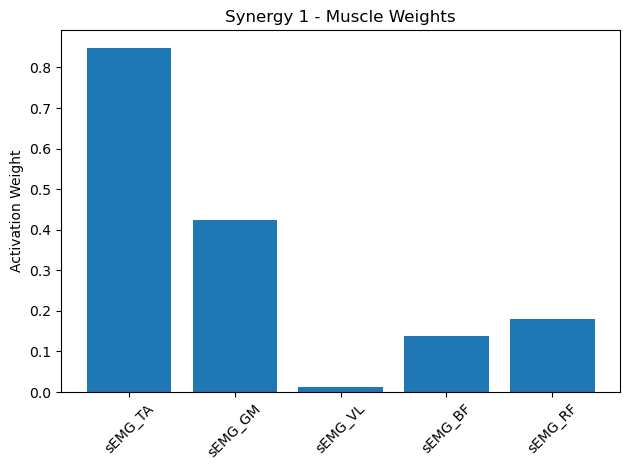

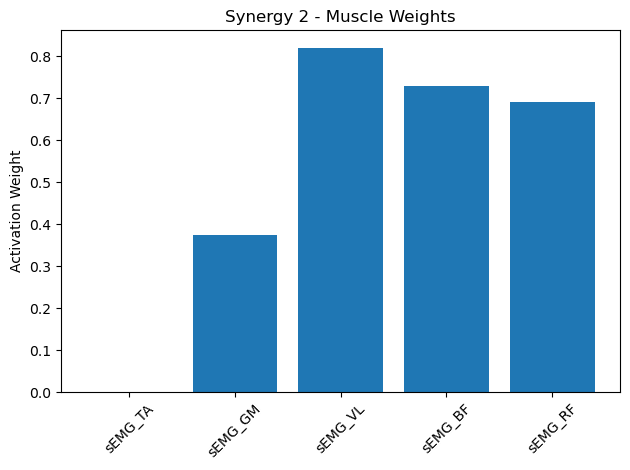

In [15]:
# Plot each synergy's muscle contribution (H matrix)
for i, synergy in enumerate(H):
    plt.figure()
    plt.bar(emg_cols, synergy)
    plt.title(f"Synergy {i+1} - Muscle Weights")
    plt.ylabel("Activation Weight")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


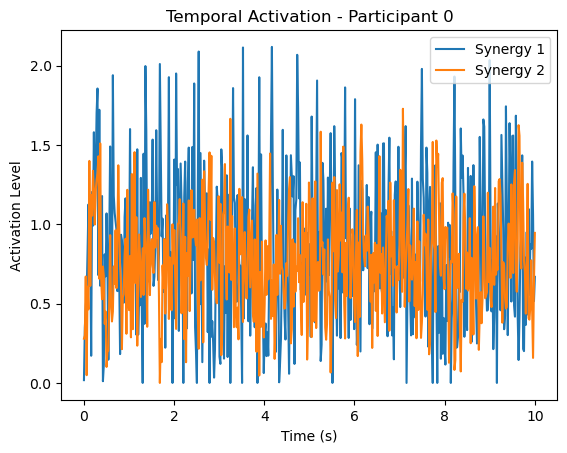

In [16]:
# Plot activation over time for each synergy
for i in range(n_synergies):
    plt.plot(df_p["time"], W[:, i], label=f"Synergy {i+1}")

plt.title(f"Temporal Activation - Participant {participant_id}")
plt.xlabel("Time (s)")
plt.ylabel("Activation Level")
plt.legend()
plt.show()


In [17]:
# Example: Mean sEMG, GRF, and synergy weights
features = []
for pid in df["participant_id"].unique():
    df_p = df[df["participant_id"] == pid]
    row = {
        "participant_id": pid,
        "group": df_p["group"].iloc[0],
        "mean_grf": df_p["ground_reaction_force"].mean(),
    }
    for col in emg_cols:
        row[f"mean_{col}"] = df_p[col].mean()
    features.append(row)

df_summary = pd.DataFrame(features)


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = df_summary.drop(["participant_id", "group"], axis=1)
y = df_summary["group"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00         7
         SCI       1.00      1.00      1.00         6

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13

